# pm2.5 training model

In [1]:
import json
import datetime as dt
import pytz
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, model_selection
from scipy import stats

## Functions that get data from server to us

In [2]:
def get_data_by_pos(pos):
    r = requests.get(f'http://140.116.82.93:6800/campus/display/{ pos }')
    # date field in self.data is the str of datetime
    # We need to convert it to timezone aware object first
    data = json.loads(r.text)
    for index, value in enumerate(data):
      # strptime() parse str of date according to the format given behind
      # It is still naive datetime object, meaning that it is unaware of timezone
      unaware = dt.datetime.strptime(value.get('date'),  '%a, %d %b %Y %H:%M:%S %Z')
      # Create a utc timezone
      utc_timezone = pytz.timezone('UTC')
      # make utc_unaware obj aware of timezone
      # Convert the given time directly to literally the same time with different timezone
      # For example: Change from 2019-05-19 07:41:13(unaware) to 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC)
      utc_aware = utc_timezone.localize(unaware)
      # This can also do the same thing
      # Replace the tzinfo of an unaware datetime object to a given tzinfo
      # utc_aware = unaware.replace(tzinfo=pytz.utc)

      # Transform utc timezone to +8 GMT timezone
      # Convert the given time to the same moment of time just like performing timezone calculation
      # For example: Change from 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC) to 2019-05-19 15:41:13+08:00(aware, tzinfo=Asiz/Taipei)
      taiwan_aware = utc_aware.astimezone(pytz.timezone('Asia/Taipei'))
      # print(f"{ index }: {unaware} {utc_aware} {taiwan_aware}")
      value['date'] = taiwan_aware
    return data

In [3]:
def get_all_data():
    r = requests.get(f'http://140.116.82.93:6800/training')
    # date field in self.data is the str of datetime
    # We need to convert it to timezone aware object first
    data = json.loads(r.text)
    for index, value in enumerate(data):
      # strptime() parse str of date according to the format given behind
      # It is still naive datetime object, meaning that it is unaware of timezone
      unaware = dt.datetime.strptime(value.get('date'),  '%a, %d %b %Y %H:%M:%S %Z')
      # Create a utc timezone
      utc_timezone = pytz.timezone('UTC')
      # make utc_unaware obj aware of timezone
      # Convert the given time directly to literally the same time with different timezone
      # For example: Change from 2019-05-19 07:41:13(unaware) to 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC)
      utc_aware = utc_timezone.localize(unaware)
      # This can also do the same thing
      # Replace the tzinfo of an unaware datetime object to a given tzinfo
      # utc_aware = unaware.replace(tzinfo=pytz.utc)

      # Transform utc timezone to +8 GMT timezone
      # Convert the given time to the same moment of time just like performing timezone calculation
      # For example: Change from 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC) to 2019-05-19 15:41:13+08:00(aware, tzinfo=Asiz/Taipei)
      taiwan_aware = utc_aware.astimezone(pytz.timezone('Asia/Taipei'))
      # print(f"{ index }: {unaware} {utc_aware} {taiwan_aware}")
      value['date'] = taiwan_aware
    return data

## 特定一個 position 的 Linear Regression

如果下一小時的 pm2.5 平均無法取得(資料缺失)，則將該 row 捨棄。拿來訓練的 columns 目前有 'pm2.5', 'temp', 'humidity'。

並嘗試用一樣的方法預測下`N`個小時的pm2.5平均。


In [4]:
def predict_next_n(pos, n):    
    # Load data
    data3 = get_data_by_pos(pos)
    df3 = pd.DataFrame(data3)
    # Input time
    time = ['2019 05 11', '2019 08 06']
    taipei_tz = pytz.timezone('Asia/Taipei')
    # Set time
    start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
    end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
    # Select the duration
    # df3 = df3.loc[ df3['date'] >= start_time ]
    # df3 = df3.loc[ df3['date'] <= end_time ]
    if pos == 2:
        # Input time
        time = ['2019 06 06', '2019 08 06']
        taipei_tz = pytz.timezone('Asia/Taipei')
        # Set time
        start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
        end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
        # Select the duration
        df3 = df3.loc[ df3['date'] >= start_time ]
        # df3 = df3.loc[ df3['date'] <= end_time ]
    # Rename the names of columns
    df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
    # Exclude outliers
    # want_cols = ['humidity', 'pm1.0', 'pm10.0', 'pm2.5', 'temp']
    # df3 = df3[(np.abs(stats.zscore(df3.loc[:, want_cols])) < 4).all(axis=1)]
    df3 = df3.loc[ df3['pm2.5'] < 120 ]
    # Split time infomation from column `date`
    df3['month'] = df3['date'].apply(lambda x: x.month)
    df3['day'] = df3['date'].apply(lambda x: x.day)
    df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
    df3['hour'] = df3['date'].apply(lambda x: x.hour)
    df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)
    # Set the order of the columns & discard some columns
    df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
    # Evaluate mean values for each hour
    df3mean = df3.groupby(['month', 'day', 'hour']).mean()
    df3mean.reset_index(inplace=True)
    # Reconstruct time infomation by `month`, `day`, and `hour`
    
    def get_time(x):
        time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
        taipei_tz = pytz.timezone('Asia/Taipei')
        time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
        return time
    
    df3mean['time'] = df3mean[['month', 'day', 'hour']].apply(get_time, axis=1)
    # Shift columns
    df3mean[['pm2.5_shift-1']] = df3mean[['pm2.5']].shift(-n)
    df3mean[['time_shift-1']] = df3mean[['time']].shift(-n)
    # Check the next row is the next hour or not. 
    # If it is not, the `pm2.5_next_hour` column will be given NaN.
    
    def check_next_hour(x):
        n_hour = dt.timedelta(hours=n)
        if x[2] - x[1] == n_hour:
            return x[0]
        return np.nan
    
    df3mean['pm2.5_next_hour'] = df3mean[['pm2.5_shift-1', 'time', 'time_shift-1']].apply(check_next_hour, axis=1)
    # Discard rows that contain NaN value
    df3mean.dropna(inplace=True)
    # Save time infomation in another df, and discard it
    df3mean_time = df3mean['time']
    df3mean_time_shift = df3mean['time_shift-1']
    df3mean.drop(columns=['time', 'time_shift-1'], axis=0, inplace=True)
    # Save mean and std
    mean_all = df3mean.mean()
    std_all = df3mean.std()
    # Normalization
    df3mean = (df3mean - df3mean.mean()) / df3mean.std()
    # Divid training set and test set
    four_fifth_len = len(df3mean)*0.8
    four_fifth_len = int(four_fifth_len)

    train_df = df3mean[:four_fifth_len]
    test_df = df3mean[four_fifth_len:]

    train_df_time_shift = df3mean_time_shift[:four_fifth_len]
    test_df_time_shift = df3mean_time_shift[four_fifth_len:]
    
    test_df_time = df3mean_time[four_fifth_len:]

    X = train_df[['month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
    y = train_df[['pm2.5_next_hour']]

    test_X = test_df[['month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
    test_y = test_df[['pm2.5_next_hour']]
    # Select features I want
    X_fsm = X[['pm2.5', 'temp', 'humidity']]
    test_X_fsm = test_X[['pm2.5', 'temp', 'humidity']]
    # Fit the model
    model = linear_model.LinearRegression(normalize=True)
    model.fit(X_fsm, y)
    # See the coefficients of our model
    for i in range(len(X_fsm.columns)):
        print('Coefficient for %10s:\t%s' % (X_fsm.columns[i], model.coef_[0][i]))
    # Calculate predict value
    predict_train_y = model.predict(X_fsm)
    predict_y = model.predict(test_X_fsm)
    # Transform normalized data back to original data
    m = mean_all['pm2.5_next_hour']
    s = std_all['pm2.5_next_hour']
    
    test_y_ori = test_y * s + m
    predict_y_ori = predict_y * s + m

    y_ori = y * s + m
    predict_train_y_ori = predict_train_y * s + m
    # Calculate mean squared error for training set & test set
    train_mse = metrics.mean_squared_error(y_ori, predict_train_y_ori)
    test_mse = metrics.mean_squared_error(test_y_ori, predict_y_ori)

    print('Train MSE:\t %s,\t sqrt: %s (μg/m^3)' % (train_mse, np.sqrt(train_mse)))
    print('Test MSE:\t %s,\t sqrt: %s (μg/m^3)' % (test_mse, np.sqrt(test_mse)))
    # Add explicitly converter
    pd.plotting.register_matplotlib_converters()
    # Plt
    plt.figure(figsize=(12, 7))
    plt.style.use('ggplot')
    plt.plot(test_df_time_shift, test_y_ori, label='actual value')
    plt.plot(test_df_time_shift, predict_y_ori, label='predict value')
    plt.xticks(rotation=45)
    plt.ylabel('(μg/m^3)')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.title('Testing set')
    plt.show()

Coefficient for      pm2.5:	0.9149133409205066
Coefficient for       temp:	-0.1333073157113654
Coefficient for   humidity:	-0.11666595262989335
Train MSE:	 16.14182348148888,	 sqrt: 4.0176888233770525 (μg/m^3)
Test MSE:	 16.27245577169132,	 sqrt: 4.033913208249691 (μg/m^3)


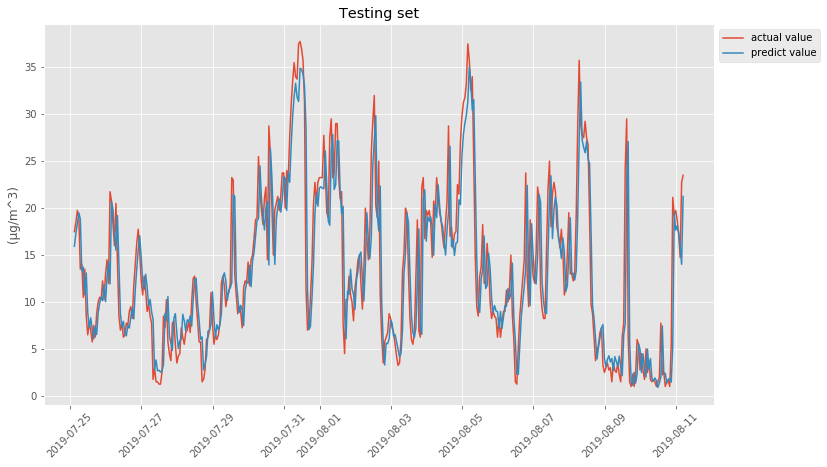

In [5]:
predict_next_n(pos=3, n=1)

記錄各個位置的誤差 (8/6)

隔一個小時的

| Position  | 0    | 1    | 2    | 3    | 4    | 5    | 6    | 7    |
| --------- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| Train     | 5.09 | 3.40 | 3.93 | 4.07 | 3.88 | 3.98 | 3.08 | 4.11 |
| Test      | 4.49 | 4.30 | 4.14 | 3.69 | 4.21 | 3.84 | 4.55 | 3.97 |

隔兩個小時的

| Position  | 0    | 1    | 2    | 3    | 4    | 5    | 6    | 7    |
| --------- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| Train     | 7.26 | 4.83 | 4.88 | 5.74 | 5.21 | 5.80 | 4.43 | 5.99 |
| Test      | 6.14 | 6.25 | 5.95 | 5.09 | 5.93 | 5.34 | 6.42 | 5.67 |

隔三個小時的

| Position  | 0    | 1    | 2    | 3    | 4    | 5    | 6    | 7    |
| --------- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| Train     | 8.41 | 5.65 | 5.56 | 6.69 | 5.90 | 6.90 | 5.38 | 7.11 |
| Test      | 6.85 | 7.23 | 6.73 | 5.80 | 6.80 | 6.19 | 7.01 | 6.47 |


In [6]:
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [7]:
def predict_prophet(pos):
    # Load data
    data3 = get_data_by_pos(pos)
    df3 = pd.DataFrame(data3)
    # Input time
    time = ['2019 05 11', '2019 08 06']
    taipei_tz = pytz.timezone('Asia/Taipei')
    # Set time
    start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
    end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
    # Select the duration
    # df3 = df3.loc[ df3['date'] >= start_time ]
    # df3 = df3.loc[ df3['date'] <= end_time ]
    # Rename the names of columns
    df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
    # Exclude outliers
    df3 = df3.loc[ df3['pm2.5'] < 120 ]
    # Split time infomation from column `date`
    df3['month'] = df3['date'].apply(lambda x: x.month)
    df3['day'] = df3['date'].apply(lambda x: x.day)
    df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
    df3['hour'] = df3['date'].apply(lambda x: x.hour)
    df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)
    # Set the order of the columns & discard some columns
    df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
    # Evaluate mean values for each hour
    df3mean = df3.groupby(['month', 'day', 'hour']).mean()
    df3mean.reset_index(inplace=True)
    # Reconstruct time infomation by `month`, `day`, and `hour`

    def get_time(x):
        time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
        taipei_tz = pytz.timezone('Asia/Taipei')
        time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
        return time

    df3mean['time'] = df3mean[['month', 'day', 'hour']].apply(get_time, axis=1)
    # Create another df for fitting model
    df_4_fit = pd.DataFrame(columns=['ds_tz','y'])
    df_4_fit['ds_tz'] = df3mean['time']
    df_4_fit['y'] = df3mean['pm2.5'].values
    # Input time
    time = '2019 07 22'
    taipei_tz = pytz.timezone('Asia/Taipei')
    # Set time
    middle_time = dt.datetime.strptime(time, '%Y %m %d').replace(tzinfo=taipei_tz)
    # Divid training set and test set
    train_prophet = df_4_fit[df_4_fit['ds_tz'] < middle_time]
    test_prophet = df_4_fit[df_4_fit['ds_tz'] >= middle_time]
    # Discard timezone info
    train_prophet['ds'] = train_prophet['ds_tz'].values
    test_prophet['ds'] = test_prophet['ds_tz'].values
    # Fit the model
    m = Prophet(yearly_seasonality=False)
    m.fit(train_prophet)
    # 未來要預測的頻率（天、週….）與長度需要先用make_future_dataframe定義好，再利用模型預測數值
    future = m.make_future_dataframe(freq = 'H', periods=len(test_prophet))
    # Predict
    forecast = m.predict(future)
    # 
    predict_y = forecast[['ds', 'yhat']]
    # Add timezone
    test_prophet['ds'] = test_prophet['ds'].apply(lambda x: x.tz_localize('UTC'))
    test_prophet['ds'] = test_prophet['ds'].apply(lambda x: x.astimezone(pytz.timezone('Asia/Taipei')))
    predict_y['ds'] = predict_y['ds'].apply(lambda x: x.tz_localize('UTC'))
    predict_y['ds'] = predict_y['ds'].apply(lambda x: x.astimezone(pytz.timezone('Asia/Taipei')))
    # Select time
    test_prophet = test_prophet[test_prophet['ds'] > middle_time]
    predict_y = predict_y[predict_y['ds'] > middle_time]
    # Calculate mean squared error for test set
    test_mse = metrics.mean_squared_error(test_prophet['y'], predict_y['yhat'])
    print('Test MSE:\t %s,\t RMSE: %s (μg/m^3)' % (test_mse, np.sqrt(test_mse)))
    # Calculate mean absolute percentage error for test set
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    test_mape = mean_absolute_percentage_error(test_prophet['y'], predict_y['yhat'])
    print('Test MAPE:\t %s %%' % test_mape)
    # Add explicitly converter
    pd.plotting.register_matplotlib_converters()
    # Plt
    plt.figure(figsize=(12, 8))
    plt.style.use('ggplot')
    plt.plot(test_prophet['ds'], test_prophet['y'], label='actual value')
    plt.plot(predict_y['ds'], predict_y['yhat'], label='predict value')
    plt.xticks(rotation=45)
    plt.ylabel('(μg/m^3)')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.title('Prophet: Testing set')
    plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

Test MSE:	 107.34212806133306,	 RMSE: 10.360604618521695 (μg/m^3)
Test MAPE:	 133.47873903148653 %


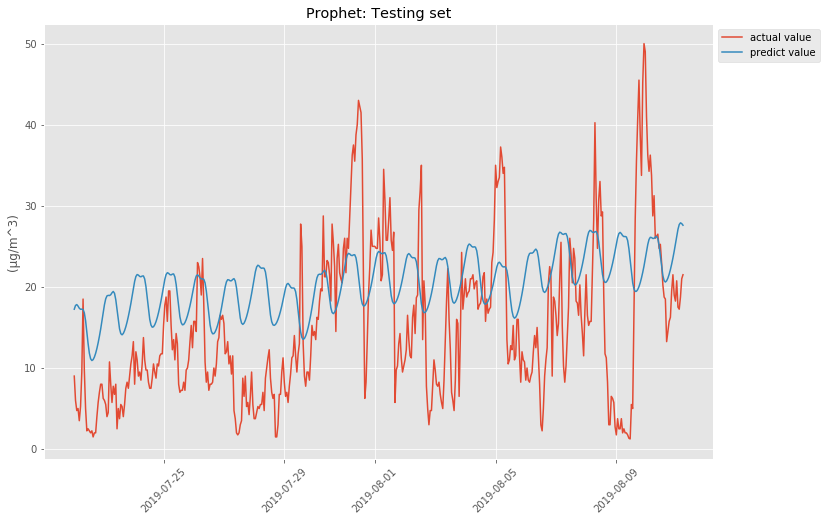

In [33]:
predict_prophet(5)

In [9]:
from statsmodels.tsa.api import ExponentialSmoothing

In [18]:
def predict_Holt_Winters(pos):
    # Load data
    data3 = get_data_by_pos(pos)
    df3 = pd.DataFrame(data3)
    # Input time
    time = ['2019 05 11', '2019 08 06']
    taipei_tz = pytz.timezone('Asia/Taipei')
    # Set time
    start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
    end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
    # Select the duration
    # df3 = df3.loc[ df3['date'] >= start_time ]
    # df3 = df3.loc[ df3['date'] <= end_time ]
    # Rename the names of columns
    df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
    # Exclude outliers
    df3 = df3.loc[ df3['pm2.5'] < 120 ]
    # Split time infomation from column `date`
    df3['month'] = df3['date'].apply(lambda x: x.month)
    df3['day'] = df3['date'].apply(lambda x: x.day)
    df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
    df3['hour'] = df3['date'].apply(lambda x: x.hour)
    df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)
    # Set the order of the columns & discard some columns
    df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
    # Evaluate mean values for each hour
    df3mean = df3.groupby(['month', 'day', 'hour']).mean()
    df3mean.reset_index(inplace=True)
    # Reconstruct time infomation by `month`, `day`, and `hour`

    def get_time(x):
        time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
        taipei_tz = pytz.timezone('Asia/Taipei')
        time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
        return time

    df3mean['time'] = df3mean[['month', 'day', 'hour']].apply(get_time, axis=1)
    # Divid training set and test set
    four_fifth_len = len(df3mean)*0.8
    four_fifth_len = int(four_fifth_len)
    train_df = df3mean[:four_fifth_len]
    test_df = df3mean[four_fifth_len:]
    # Fit the model
    Holt_Winters_model = ExponentialSmoothing(np.asarray(train_df['pm2.5']), 
                                              seasonal_periods=24, 
                                              trend='add', 
                                              seasonal='add', 
                                              damped=True).fit()
    # Predict
    predict_y = Holt_Winters_model.forecast(len(test_df))
    # Calculate mean squared error for test set
    test_mse = metrics.mean_squared_error(test_df['pm2.5'], predict_y)
    print('Test MSE:\t %s,\t RMSE: %s (μg/m^3)' % (test_mse, np.sqrt(test_mse)))
    # Calculate mean absolute percentage error for test set

    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    test_mape = mean_absolute_percentage_error(test_df['pm2.5'], predict_y)
    print('Test MAPE:\t %s %%' % test_mape)
    # Add explicitly converter
    pd.plotting.register_matplotlib_converters()
    # Plt
    plt.figure(figsize=(12, 8))
    plt.style.use('ggplot')
    plt.plot(test_df['time'], test_df['pm2.5'], label='actual value')
    plt.plot(test_df['time'], predict_y, label='predict value')
    plt.xticks(rotation=45)
    plt.ylabel('(μg/m^3)')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.title('Holt-Winters\' Method: Testing set')
    plt.show()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Test MSE:	 125.16401341717487,	 RMSE: 11.18767238603164 (μg/m^3)
Test MAPE:	 67.0175315936962 %


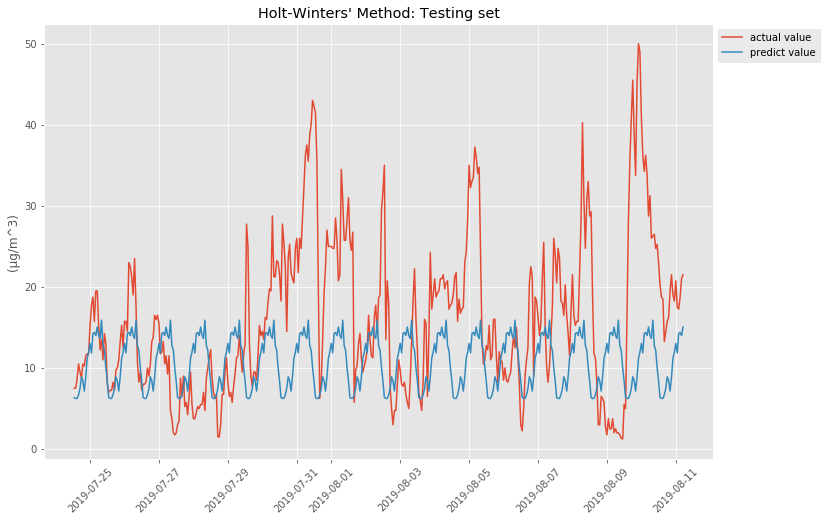

In [29]:
predict_Holt_Winters(5)